In [1]:
import copy
import random
from collections import defaultdict

import numpy as np
import tqdm
from IPython import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from utils.splus import splus

In [2]:
class RiverSwim:
    def __init__(self, current='WEAK', seed=1234):
        self.num_states = 6
        self.num_actions = 2  # O <=> LEFT, 1 <=> RIGHT

        # Larger current makes it harder to swim up the river
        self.currents = ['WEAK', 'MEDIUM', 'STRONG']
        assert current in self.currents
        self.current = self.currents.index(current) + 1
        assert self.current in [1, 2, 3]

        # Configure reward function
        R = np.zeros((self.num_states, self.num_actions))
        R[0, 0] = 0.005
        R[5, 1] = 0.6

        # Configure transition function
        T = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Encode initial and rewarding state transitions
        left, right = 0, 1
        T[0, left, 0] = 1.
        T[0, right, 0] = 0.4
        T[0, right, 1] = 0.6

        T[5, left, 4] = 1.
        T[5, right, 5] = 0.6
        T[5, right, 4] = 0.4

        # Encode intermediate state transitions
        for s in range(1, self.num_states - 1):
            # Going left always succeeds
            T[s, left, s - 1] = 1.

            # Going right sometimes succeeds
            T[s, right, s] = 0.6
            T[s, right, s - 1] = 0.05 * self.current
            T[s, right, s + 1] = 0.4 - 0.05 * self.current
            assert np.isclose(np.sum(T[s, right]), 1.)

        self.R = np.array(R)
        self.T = np.array(T)

        # Agent always starts at the opposite end of the river
        self.init_state = 0
        self.curr_state = self.init_state

        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_model(self):
        return copy.deepcopy(self.R), copy.deepcopy(self.T)

    def reset(self):
        return self.init_state

    def step(self, action):
        reward = self.R[self.curr_state, action]
        next_state = np.random.choice(np.arange(self.num_states), p=self.T[self.curr_state, action])
        self.curr_state = next_state
        return reward, next_state


In [3]:
# collect dataset
seed = 10
discount = 0.99
env = RiverSwim(seed=seed)

# uniform behavioral policy
behavioral_policy = np.ones([env.num_states, env.num_actions]) / env.num_actions

dataset = defaultdict(list)

# dataset size = 100K
num_episodes = 1000
max_episode_steps = 101
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    obs = env.reset()
    for step in range(max_episode_steps):
        action = np.random.choice(np.arange(env.num_actions), p=behavioral_policy[obs])
        reward, next_obs = env.step(action)
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['rewards'].append(reward)
        
        obs = next_obs

    for k, v in traj_dataset.items():
        dataset[k].append(v)

train_dataset = {}
for k, v in dataset.items():
    if 'observations' in k or 'actions' in k:
        dtype = np.int32
    else:
        dtype = np.float32
    arr = np.array(v, dtype=dtype)[:, :-1]
    train_dataset[k] = arr.reshape(-1)
arr = np.array(dataset['actions'], np.int32)[:, 1:]
train_dataset['next_actions'] = arr.reshape(-1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 311.24it/s]


In [4]:
# value iteration to find the optimal Q
rewards, transition_probs = env.get_model()

opt_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_q = rewards + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.num_states, env.num_actions])
opt_policy[np.arange(env.num_states), np.argmax(opt_q, axis=-1)] = 1.0

# value iteration to find the behavioral Q
rewards, transition_probs = env.get_model()

behavioral_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  behavioral_q = rewards + discount * np.einsum('ijk,k->ij', transition_probs, np.sum(behavioral_policy * behavioral_q, axis=-1))
behavioral_v = np.sum(behavioral_policy * behavioral_q, axis=-1)

In [5]:
print("optimal q and optimal policy: ")
print(opt_q)
print(opt_policy)

print("behavioral q: ")
print(behavioral_q)

optimal q and optimal policy: 
[[22.49069248 22.71282068]
 [22.48569248 23.0951914 ]
 [22.86423949 23.81634368]
 [23.57818024 24.6067058 ]
 [24.36063874 25.42976492]
 [25.17546727 26.28124854]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
behavioral q: 
[[0.21777137 0.21206978]
 [0.21277137 0.21470753]
 [0.21160206 0.2334642 ]
 [0.2203078  0.30320977]
 [0.2591412  0.52994777]
 [0.39059904 1.2407504 ]]


#### Utils

In [6]:
def sample_batch(batch_size):
    dataset_size = len(train_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], train_dataset)
    
    return batch

In [7]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

#### Q-learning

In [8]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.num_states)
    action = jax.nn.one_hot(action, env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

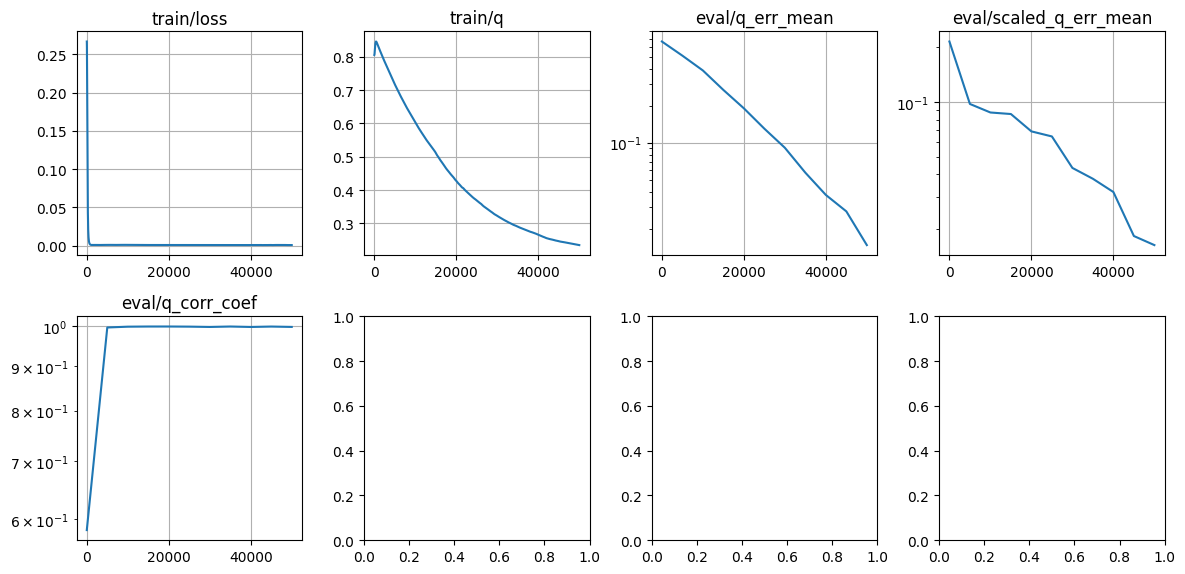

100%|██████████| 50000/50000 [01:15<00:00, 662.77it/s] 


In [9]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  # q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.num_actions), axis=-1)
  
  next_q = critic.apply(target_params, batch['next_observations'], batch['next_actions'])
  target_q = batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=3e-4 * 512 * 2)
optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params):
  obs = jnp.arange(env.num_states)[:, None].repeat(env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(env.num_actions)[None, :].repeat(env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([env.num_states, env.num_actions])
  scaled_q = q * (behavioral_q / q).mean()
  q_err_mean = jnp.mean(np.abs(q - behavioral_q))
  scaled_q_err_mean = jnp.mean(np.abs(scaled_q - behavioral_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), behavioral_q.reshape(-1))[0, 1]
  
  info = {
    'q_err_mean': q_err_mean,
    'scaled_q_err_mean': scaled_q_err_mean,
    'q_corr_coef': q_corr_coef,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/scaled_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [10]:
q_learning_metrics = metrics
print(q_learning_metrics['eval/q_err_mean'][-1])
print(q_learning_metrics['eval/scaled_q_err_mean'][-1])
print(q_learning_metrics['eval/q_corr_coef'][-1])

[5.00000000e+04 1.47261843e-02]
[5.00000000e+04 1.63542703e-02]
[5.00000000e+04 9.98778641e-01]


#### C51

In [14]:
class CategoricalCritic(nn.Module):
  atoms: jnp.ndarray
  
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.num_states)
    action = jax.nn.one_hot(action, env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)

    num_atoms = len(self.atoms)

    logits = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(num_atoms),
    ])(inputs)
    
    logits = logits.reshape([obs.shape[0], num_atoms])
    probs = jax.nn.softmax(logits, axis=-1)
    qs = jnp.sum(probs * self.atoms[None], axis=-1)

    return qs, probs

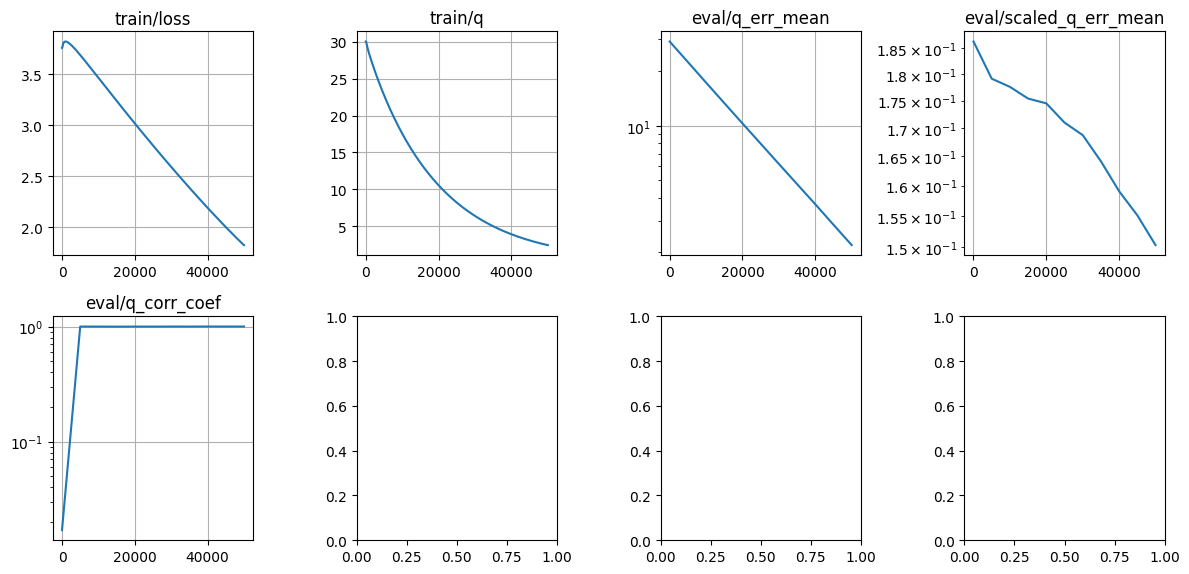

100%|██████████| 50000/50000 [01:15<00:00, 663.13it/s]


In [15]:
batch_size = 1024
tau = 0.005
num_atoms = 51
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards, _ = env.get_model()
v_min = rewards.min() / (1 - discount)
v_max = rewards.max() / (1 - discount)
# v_min = 0.0
# v_max = 1.0
atoms = jnp.linspace(v_min, v_max, num_atoms)
delta_atom = (v_max - v_min) / (num_atoms - 1)
offset = jnp.arange(batch_size, dtype=jnp.int32) * num_atoms
offset = offset[:, None]
offset = jnp.broadcast_to(offset, (batch_size, num_atoms))

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
cate_critic = CategoricalCritic(atoms)
cate_critic_params = cate_critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_cate_critic_params = copy.deepcopy(cate_critic_params)

def loss_fn(params, target_params, batch):
  q, probs = cate_critic.apply(params, batch['observations'], batch['actions'])

  _, next_probs = cate_critic.apply(target_params, batch['next_observations'], batch['next_actions'])

  projected_atoms = jnp.clip(batch['rewards'][:, None] + discount * atoms[None], v_min, v_max)
  projected_bins = (projected_atoms - v_min) / delta_atom
  lower_bins = jnp.floor(projected_bins).astype(jnp.int32)
  upper_bins = jnp.ceil(projected_bins).astype(jnp.int32)

  delta_mass_lower = (upper_bins + (lower_bins == upper_bins).astype(jnp.int32) - projected_bins) * next_probs
  delta_mass_upper = (projected_bins - lower_bins) * next_probs
  
  mass = jnp.zeros(batch_size * num_atoms)
  mass = mass.at[(lower_bins + offset).ravel()].add(delta_mass_lower.ravel())
  mass = mass.at[(upper_bins + offset).ravel()].add(delta_mass_upper.ravel())
  mass = mass.reshape(batch_size, num_atoms)

  loss = jnp.sum(-mass * jnp.log(probs + 1e-8), axis=-1).mean()
  
  # logging
  # q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.num_actions), axis=1)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=3e-4 * 512 * 2)
optimizer = optax.adam(learning_rate=5e-4)
opt_state = optimizer.init(cate_critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params):
  obs = jnp.arange(env.num_states)[:, None].repeat(env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(env.num_actions)[None, :].repeat(env.num_states, axis=0).reshape(-1)
  q, _ = cate_critic.apply(params, obs, actions)
  q = q.reshape([env.num_states, env.num_actions])
  scaled_q = q * (behavioral_q / q).mean()
  q_err_mean = jnp.mean(np.abs(q - behavioral_q))
  scaled_q_err_mean = jnp.mean(np.abs(scaled_q - behavioral_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), behavioral_q.reshape(-1))[0, 1]
  
  info = {
    'q_err_mean': q_err_mean,
    'scaled_q_err_mean': scaled_q_err_mean,
    'q_corr_coef': q_corr_coef,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  cate_critic_params, target_cate_critic_params, opt_state, loss, info = update_fn(
    cate_critic_params, target_cate_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(cate_critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/scaled_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [15]:
c51_metrics = metrics

print(c51_metrics['eval/q_err_mean'][-1])
print(c51_metrics['eval/scaled_q_err_mean'][-1])
print(c51_metrics['eval/q_corr_coef'][-1])

[5.00000000e+04 5.74145243e-02]
[5.00000000e+04 4.18254994e-02]
[5.00000000e+04 9.99371886e-01]


#### Flow distributional Q-learning

In [37]:
class CriticVectorField(nn.Module):
  @nn.compact
  def __call__(self, ret, time, obs, action):
    obs = jax.nn.one_hot(obs, env.num_states)
    action = jax.nn.one_hot(action, env.num_actions)
    inputs = jnp.concatenate([ret, time, obs, action], axis=-1)

    vector_field = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      # nn.LayerNorm(),
      nn.Dense(1),
    ])(inputs)
    
    return vector_field

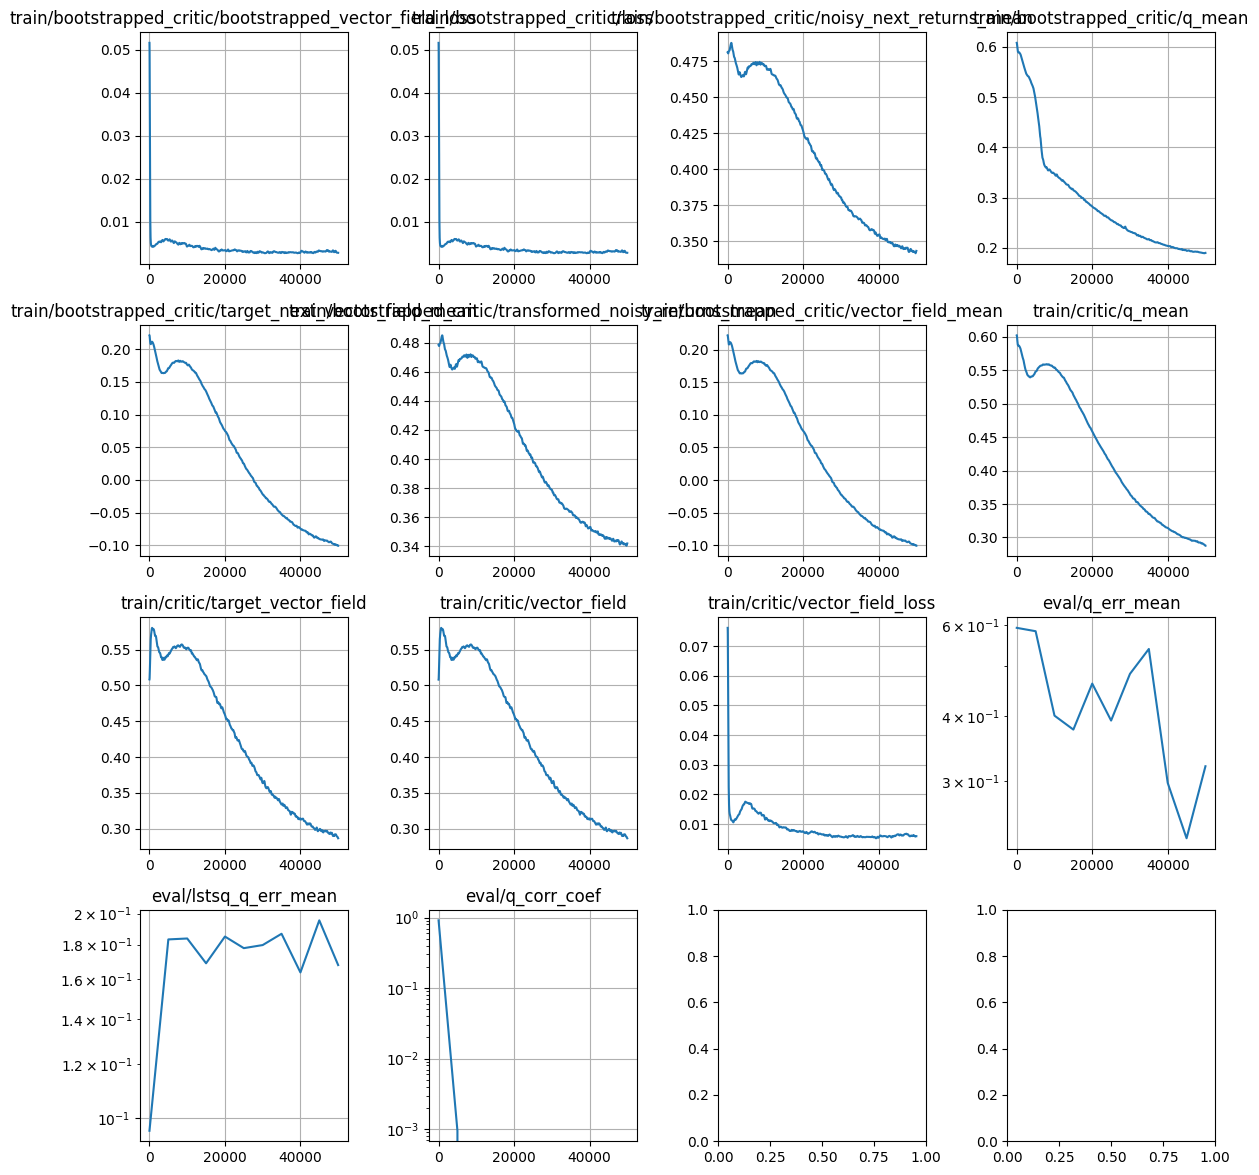

100%|██████████| 50000/50000 [03:28<00:00, 239.38it/s]


In [ ]:
batch_size = 1024
tau = 0.005
# tau = 0.0
lam = 0.01
num_flow_steps = 10
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards, _ = env.get_model()
min_reward = rewards.min()
max_reward = rewards.max()

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_vf_key, target_critic_vf_key, bootstrapped_critic_vf_key = jax.random.split(key, 4)

example_batch = sample_batch(2)
critic_vf = CriticVectorField()
bootstrapped_critic_vf = CriticVectorField()

ex_returns = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)
ex_times = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)

critic_vf_params = critic_vf.init(critic_vf_key, 
                                  ex_returns, ex_times, 
                                  example_batch['observations'], example_batch['actions'])
target_critic_vf_params = copy.deepcopy(critic_vf_params)
bootstrapped_critic_vf_params = bootstrapped_critic_vf.init(
  bootstrapped_critic_vf_key, 
  ex_returns, ex_times, 
  example_batch['observations'], example_batch['actions']
)

@jax.jit
def compute_flow_returns(
  params,
  noises,
  observations,
  actions,
  init_times=None,
  end_times=None,
  vector_field_fn=critic_vf,
):
  """Compute returns from the return flow model using the Euler method."""
  noisy_returns = noises
  if init_times is None:
    init_times = jnp.zeros((*noisy_returns.shape[:-1], 1), dtype=noisy_returns.dtype)
  if end_times is None:
    end_times = jnp.ones((*noisy_returns.shape[:-1], 1), dtype=noisy_returns.dtype)
  step_size = (end_times - init_times) / num_flow_steps

  def func(carry, i):
    """
    carry: (noisy_goals, )
    i: current step index
    """
    (noisy_returns, ) = carry

    times = i * step_size + init_times
    
    # euler method
    vector_field = critic_vf.apply(
      params, noisy_returns, times, observations, actions)
    new_noisy_returns = noisy_returns + step_size * vector_field
    
    # midpoint method
    # mid_vector_field = critic_vf.apply(
    #   params, noisy_returns, times, observations, actions)
    # mid_noisy_returns = noisy_returns + 0.5 * step_size * mid_vector_field
    # mid_times = times + 0.5 * step_size
    # vector_field = critic_vf.apply(
    #   params, mid_noisy_returns, mid_times, observations, actions)
    # new_noisy_returns = noisy_returns + step_size * vector_field
    
    new_noisy_returns = jnp.clip(
      new_noisy_returns,
      min_reward / (1.0 - discount),
      max_reward / (1.0 - discount),
    )

    return (new_noisy_returns, ), None

  # Use lax.scan to do the iteration
  (noisy_returns, ), _ = jax.lax.scan(
      func, (noisy_returns,), jnp.arange(num_flow_steps))
  # noisy_returns = jnp.clip(
  #   noisy_returns,
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )

  return noisy_returns

def fm_loss_fn(params, target_params, batch, rng):
  rng, noise_rng, time_rng, q_rng = jax.random.split(rng, 4)
  
  next_actions = batch['next_actions']
  noises = jax.random.normal(noise_rng, (batch_size, 1))
  next_returns = compute_flow_returns(
    target_params, noises, batch['next_observations'], next_actions)
  returns = jnp.expand_dims(batch['rewards'], axis=-1) + discount * next_returns
  # returns = jnp.clip(
  #   returns,
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )

  times = jax.random.uniform(time_rng, (batch_size, 1))
  # rng, noise_rng = jax.random.split(rng)
  # noises = jax.random.normal(noise_rng, (batch_size, 1))
  noisy_returns = times * returns + (1.0 - times) * noises
  target_vector_field = returns - noises
  
  vector_field = critic_vf.apply(params, noisy_returns, times, batch['observations'], batch['actions'])
  vector_field_loss = jnp.mean((vector_field - target_vector_field) ** 2)
  
  # Additional metrics for logging.
  q_noises = jax.random.normal(q_rng, (batch_size, 1))
  q = compute_flow_returns(
    params, q_noises, batch['observations'], batch['actions'])
  
  info = {
    'vector_field_loss': vector_field_loss,
    'vector_field': vector_field.mean(),
    'target_vector_field': target_vector_field.mean(),
    'q_mean': q.mean(),
  }
  
  return vector_field_loss, info

def bootstrapped_loss_fn(params, target_params, batch, rng):
  rng, noise_rng, time_rng, q_rng = jax.random.split(rng, 4)
  next_actions = batch['next_actions']
  
  times = jax.random.uniform(time_rng, (batch_size, 1))
  
  rng, noise_rng = jax.random.split(rng)
  noises = jax.random.normal(noise_rng, (batch_size, 1))
  noisy_next_returns = compute_flow_returns(
    target_params, noises, batch['next_observations'], next_actions, end_times=times)
  transformed_noisy_returns = jnp.expand_dims(batch['rewards'], axis=-1) + discount * noisy_next_returns
  transformed_noisy_returns = jnp.clip(
    transformed_noisy_returns,
    min_reward / (1.0 - discount),
    max_reward / (1.0 - discount),
  )

  vector_field = bootstrapped_critic_vf.apply(
    params, transformed_noisy_returns, times, batch['observations'], batch['actions'])
  # vector_field = jnp.clip(
  #   vector_field, 
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )
  # next_vector_field = critic_vf.apply(
  #   params, noisy_next_returns, times, batch['next_observations'], next_actions)
  # target_vector_field = critic_vf.apply(
  #   target_params, transformed_noisy_returns, times, batch['observations'], batch['actions'])
  target_next_vector_field = bootstrapped_critic_vf.apply(
    target_params, noisy_next_returns, times, batch['next_observations'], next_actions)
  # target_next_vector_field = jnp.clip(
  #   target_next_vector_field,
  #   min_reward / (1.0 - discount),
  #   max_reward / (1.0 - discount),
  # )
  # bootstrapped_vector_field_loss = jnp.mean((vector_field - target_next_vector_field) ** 2 +
  #                                           (next_vector_field - target_vector_field) ** 2)
  bootstrapped_vector_field_loss = jnp.mean((vector_field - target_next_vector_field) ** 2)
  
  # norm_vector_field, norm_target_next_vector_field = jax.lax.stop_gradient(jnp.linalg.norm(vector_field, axis=-1)), jax.lax.stop_gradient(jnp.linalg.norm(target_next_vector_field, axis=-1))
  # bootstrapped_vector_field_loss = -jnp.mean(jnp.sum(vector_field * target_next_vector_field, axis=-1) / (norm_vector_field * norm_target_next_vector_field))
  # bootstrapped_vector_field_loss = optax.sigmoid_binary_cross_entropy(
  #   vector_field / jax.lax.stop_gradient(jnp.abs(vector_field)),
  #   # vector_field / jnp.abs(vector_field),
  #   target_next_vector_field / jax.lax.stop_gradient(jnp.abs(target_next_vector_field)),
  #   # target_next_vector_field / jnp.abs(target_next_vector_field),
  # ).mean()
  
  # loss = vector_field_loss + lam * bootstrapped_vector_field_loss
  loss = bootstrapped_vector_field_loss
  
  # Additional metrics for logging.
  q_noises = jax.random.normal(q_rng, (batch_size, 1))
  q = compute_flow_returns(
    params, q_noises, batch['observations'], batch['actions'])
  # q = (q_noises + critic_vf.apply(
  #   params, q_noises, jnp.zeros((batch_size, 1)), 
  #   batch['observations'], batch['actions']))

  info = {
    'loss': loss,
    # 'vector_field_loss': vector_field_loss,
    'bootstrapped_vector_field_loss': bootstrapped_vector_field_loss,
    'vector_field_mean': vector_field.mean(),
    # 'vector_field_max': vector_field.max(),
    # 'vector_field_min': vector_field.min(),
    'target_next_vector_field_mean': target_next_vector_field.mean(),
    # 'target_next_vector_field_max': target_next_vector_field.max(),
    # 'target_next_vector_field_min': target_next_vector_field.min(),
    'noisy_next_returns_mean': noisy_next_returns.mean(),
    # 'noisy_next_returns_min': noisy_next_returns.min(),
    # 'noisy_next_returns_max': noisy_next_returns.max(),
    'transformed_noisy_returns_mean': transformed_noisy_returns.mean(),
    # 'transformed_noisy_returns_min': transformed_noisy_returns.min(),
    # 'transformed_noisy_returns_max': transformed_noisy_returns.max(),
    'q_mean': q.mean(),
  }
  
  return loss, info

# optimizer = splus(learning_rate=5e-4 * 512 * 2)
critic_optimizer = optax.adam(learning_rate=1e-3)
bootstrapped_critic_optimizer = optax.adam(learning_rate=1e-3)
critic_opt_state = critic_optimizer.init(critic_vf_params)
bootstrapped_critic_opt_state = bootstrapped_critic_optimizer.init(bootstrapped_critic_vf_params)
critic_grad_fn = jax.value_and_grad(fm_loss_fn, has_aux=True)
bootstrapped_critic_grad_fn = jax.value_and_grad(bootstrapped_loss_fn, has_aux=True)

@jax.jit
def update_fn(critic_params, target_critic_params, boostrapped_critic_params, 
              critic_opt_state, bootstrapped_critic_opt_state, 
              batch, rng):
  rng, critic_rng, bootstrapped_critic_rng = jax.random.split(rng, 3)
  
  (_, critic_info), critic_grads = critic_grad_fn(
    critic_params, target_critic_params, batch, critic_rng)
  critic_updates, critic_opt_state = critic_optimizer.update(
    critic_grads, critic_opt_state, critic_params)
  critic_params = optax.apply_updates(critic_params, critic_updates)
  
  (_, bootstrapped_critic_info), bootstrapped_critic_grads = bootstrapped_critic_grad_fn(
    boostrapped_critic_params, critic_params, batch, bootstrapped_critic_rng)
  bootstrapped_critic_updates, bootstrapped_critic_opt_state = bootstrapped_critic_optimizer.update(
    bootstrapped_critic_grads, bootstrapped_critic_opt_state, boostrapped_critic_params)
  boostrapped_critic_params = optax.apply_updates(boostrapped_critic_params, bootstrapped_critic_updates)
  
  target_critic_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    critic_params, target_critic_params,
  )
  
  info = dict()
  for k, v in critic_info.items():
    info['critic/' + k] = v
  for k, v in bootstrapped_critic_info.items():
    info['bootstrapped_critic/' + k] = v
  
  return critic_params, target_critic_params, boostrapped_critic_params, critic_opt_state, bootstrapped_critic_opt_state, info

def evaluate_fn(params, rng):
  obs = jnp.arange(env.num_states)[:, None].repeat(env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(env.num_actions)[None, :].repeat(env.num_states, axis=0).reshape(-1)

  rng, q_rng = jax.random.split(rng)
  q_noises = jax.random.normal(q_rng, (obs.shape[0], 1))
  q = compute_flow_returns(
    params, q_noises, obs, actions)
  # q = (q_noises + critic_vf.apply(
  #   params, q_noises, jnp.zeros((obs.shape[0], 1)), 
  #   obs, actions))
  q = q.reshape(env.num_states, env.num_actions)
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    behavioral_q.reshape(-1),
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - behavioral_q))
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - behavioral_q))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), behavioral_q.reshape(-1))[0, 1]
  
  info = {
    'q_err_mean': q_err_mean,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'q_corr_coef': q_corr_coef,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  key, train_key = jax.random.split(key)
  batch = sample_batch(batch_size)
  
  (critic_vf_params, target_critic_vf_params, bootstrapped_critic_vf_params, 
   critic_opt_state, bootstrapped_critic_opt_state, 
   info) = update_fn(
    critic_vf_params, target_critic_vf_params, bootstrapped_critic_vf_params, 
    critic_opt_state, bootstrapped_critic_opt_state, batch, train_key
  )

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    key, eval_key = jax.random.split(key)
    eval_info = evaluate_fn(critic_vf_params, eval_key)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [34]:
# lam = 0.01
fdql_metrics = metrics
print(fdql_metrics['eval/q_err_mean'][-1])
print(fdql_metrics['eval/lstsq_q_err_mean'][-1])
print(fdql_metrics['eval/q_corr_coef'][-1])

[5.00000000e+04 1.70000881e-01]
[5.00000000e+04 1.52781188e-01]
[5.00000000e+04 5.11047184e-01]


#### Plot curves

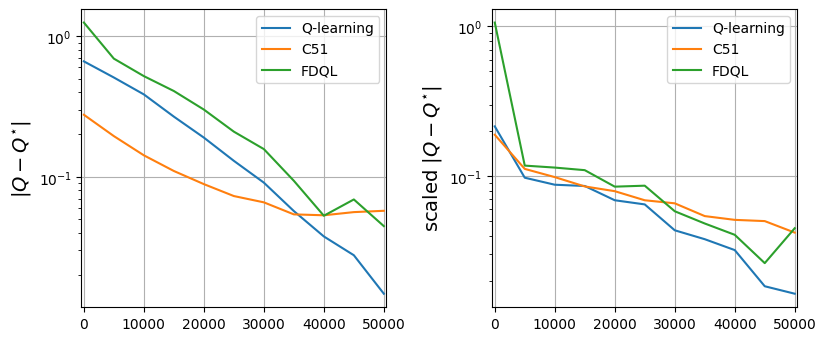

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.2))

metric_name = 'eval/q_err_mean'
ax = axes[0]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'$| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()
ax.grid(zorder=3)     


metric_name = 'eval/scaled_q_err_mean'
ax = axes[1]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'scaled $| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()

# ax.set_ylim([-5, 120 + 5])
# ax.set_yticks([0, 120])
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.grid(zorder=3)     

fig.tight_layout(rect=(-0.026, -0.06, 1.02, 1.04))  # rect = (left, bottom, right, top), default: (0, 0, 1, 1)
# filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/convergence_speed_ablation_lc.pdf"
# fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
